# Weather Prediction Example
This template shows how to fetch weather data for a particular zip code from the Metis Machine data engine, and then use those data to train a dummy [recurrent neural network](https://en.wikipedia.org/wiki/Recurrent_neural_network) that will predict some aspect of the weather from the historical time series at that location.
Obviously, weather modeling is not actually this easy, but the following code shows how to:
* access data via the Metis Machine data engine
* transform those data using a deep learning model
* persist the resulting transformation so that it can be accessed via an outward-facing API

### Install additional dependencies into the generic notebook environment
For this example, we need pytorch for deep learning and ggplot for visualization

In [1]:
! pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl torchvision ggplot

    100% |████████████████████████████████| 592.3MB 76.9MB/s ta 0:00:01   15% |████▉                           | 89.1MB 80.2MB/s eta 0:00:07    53% |█████████████████▎              | 319.4MB 53.3MB/s eta 0:00:06    57% |██████████████████▎             | 338.6MB 50.8MB/s eta 0:00:05    64% |████████████████████▋           | 381.5MB 63.6MB/s eta 0:00:04    72% |███████████████████████▎        | 431.7MB 54.9MB/s eta 0:00:03    79% |█████████████████████████▌      | 472.1MB 54.5MB/s eta 0:00:03    85% |███████████████████████████▍    | 506.3MB 56.3MB/s eta 0:00:02�███████████████████████    | 520.0MB 59.4MB/s eta 0:00:02�████████████████▎   | 523.1MB 79.4MB/s eta 0:00:01   89% |████████████████████████████▌   | 527.2MB 72.7MB/s eta 0:00:01   89% |████████████████████████████▊   | 530.7MB 80.2MB/s eta 0:00:01   90% |████████████████████████████▉   | 534.1MB 72.2MB/s eta 0:00:01.0MB/s eta 0:00:01��█▎  | 541.0MB 76.6MB/s eta 0:00:01█████▍  | 544.5MB 67.8MB/s eta 0:00:01�██████████████████████

In [2]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from datetime import datetime
import pandas as pd

## Access weather data using the Metis Machine SDK
Any data intake or model project on the platform begins by initializing the Skafos SDK.
This allows your task to access the resources of the platform, as well as ensures proper health monitoring.

*Unresponsive tasks will eventually be purged.*

In [3]:
from skafossdk import *
print('Initializing the SDK connection')
skafos = Skafos()

Initializing the SDK connection
2018-01-05 20:41:56,296 - skafossdk.data_engine - INFO - DataEngine Connection Opened


In [4]:
res = skafos.engine.create_view(
    "weather_noaa", {"keyspace": "weather",
                      "table": "weather_noaa"}, DataSourceType.Cassandra).result()
print("created a view of NOAA historial weather data")

2018-01-05 20:41:57,290 - skafossdk.data_engine - INFO - Creating View...
2018-01-05 20:41:57,293 - skafossdk.data_engine - INFO - Sending msg...
2018-01-05 20:41:57,350 - skafossdk.monitor - INFO - Monitor Connection Opened
created a view of NOAA historial weather data


In [5]:
print("pulling historical weather from a single zip code")
weather_json = skafos.engine.query("SELECT * from weather_noaa WHERE zipcode = 23250").result()

pulling historical weather from a single zip code
2018-01-05 20:42:00,117 - skafossdk.data_engine - INFO - Querying ...
2018-01-05 20:42:00,119 - skafossdk.data_engine - INFO - Sending msg...


In [6]:
# validate a single record
weather_json['data'][0]

{'date': '2008-10-03T00:00:00Z',
 'precip_total': 0.0,
 'pressure_avg': 29.81999969482422,
 'rh_avg': 66.0,
 'sunrise': '608',
 'sunset': '1747',
 'tmax': 74.0,
 'tmin': 45.0,
 'wind_speed_peak': 26.0,
 'zipcode': '23250'}

In [7]:
# convert retrieved records to a dataframe
import pandas as pd
weather = pd.DataFrame(weather_json['data'])
weather['date']  = pd.to_datetime(weather['date'])

In [8]:
# validate this is what we expect, missing values may throw off pandas types
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3550 entries, 0 to 3549
Data columns (total 10 columns):
date               3550 non-null datetime64[ns]
precip_total       3550 non-null object
pressure_avg       3550 non-null object
rh_avg             3550 non-null object
sunrise            3550 non-null object
sunset             3550 non-null object
tmax               3550 non-null float64
tmin               3549 non-null float64
wind_speed_peak    3550 non-null object
zipcode            3550 non-null object
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 277.4+ KB


In [9]:
# some numerical values do not show as such, clean missing records
weather['precip_total'] = weather['precip_total'].replace('NaN', None, regex=False).fillna(0)
weather['pressure_avg'] = weather['pressure_avg'].replace('NaN', None, regex=False).fillna(0)
weather['wind_speed_peak'] = weather['wind_speed_peak'].replace('NaN', None, regex=False).fillna(0)

In [10]:
# verify that we now have all the float columns we expected
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3550 entries, 0 to 3549
Data columns (total 10 columns):
date               3550 non-null datetime64[ns]
precip_total       3550 non-null float64
pressure_avg       3550 non-null float64
rh_avg             3550 non-null object
sunrise            3550 non-null object
sunset             3550 non-null object
tmax               3550 non-null float64
tmin               3549 non-null float64
wind_speed_peak    3550 non-null float64
zipcode            3550 non-null object
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 277.4+ KB


# Prep inputs for modeling
We want to use a recurrent time-series model, so our data need to be in ascending order by date.

In [11]:
day_zero = weather['date'].min()

In [12]:
weather.set_index((weather['date'] - day_zero).apply(lambda d: d.days), inplace=True)
weather.sort_index(inplace=True)

## Feature Engineering
These are not necessarilly excellent features, but simply illustrate a common step in the predictive process.

* length of day
* average temperature
* change in average temperature
* change in barometric pressure
* precipitation
* wind speed peak

In [13]:
weather['precip_total'].fillna(0, inplace=True)

In [14]:
weather['day_length'] = weather.apply(lambda r: int(r.sunset) - int(r.sunrise), axis=1)

In [15]:
weather['tavg'] = (weather.tmax + weather.tmin) / 2

In [16]:
weather['pressure_change'] = weather['pressure_avg'].pct_change()

In [17]:
weather['temp_change'] = weather['tavg'].pct_change()

In [18]:
weather_features = weather[
    ['day_length', 'tavg', 'tmin', 'tmax', 'temp_change', 'pressure_change', 'precip_total', 'wind_speed_peak']].dropna()

In [19]:
# validate inputs to the RNN
weather_features.iloc[:6]

,day_length,tavg,tmin,tmax,temp_change,pressure_change,precip_total,wind_speed_peak
date,,,,,,,,
1,980,32.0,27.0,37.0,-0.288889,0.004367,0.01,37.0
2,980,26.0,18.0,34.0,-0.187500,0.018395,0.00,32.0
3,981,30.5,16.0,45.0,0.173077,0.000328,0.00,22.0
4,981,38.5,26.0,51.0,0.262295,-0.008207,0.00,17.0
5,983,52.5,39.0,66.0,0.363636,-0.003972,0.84,18.0
6,984,58.5,43.0,74.0,0.114286,0.000000,0.00,16.0


## Normalize inputs for deep learning
Most neural networks expect inputs from -1 to 1

In [20]:
# fit two standard deviations between -1 and 1
weather_norm = weather_features.apply(lambda c: 0.5 * (c - c.mean()) / c.std())

In [21]:
weather_x = weather_norm.drop('tavg', axis=1)
# shift so that we're trying to predict tomorrow
weather_y = weather_norm['tavg'].shift(-1)

In [22]:
# predict on the last two months
predict_day = weather_x.index[-60]

# Recurrent Neural Network Model
[PyTorch](http://pytorch.org) is a wonderful framnework for deep learning since it handles backpropgation automatically.

In [23]:
x_train = torch.autograd.Variable(
    torch.from_numpy(weather_x.loc[:predict_day - 1].as_matrix()).float(), requires_grad=False)
x_test = torch.autograd.Variable(
    torch.from_numpy(weather_x.loc[predict_day:].as_matrix()).float(), requires_grad=False)
batch_size = x_train.size()[0]
input_size = len(weather_x.columns)

In [24]:
y_train = torch.autograd.Variable(
    torch.from_numpy(weather_y.loc[:predict_day - 1].as_matrix()).float(), requires_grad=False)
y_test = torch.autograd.Variable(
    torch.from_numpy(weather_y.loc[predict_day:].as_matrix()).float(), requires_grad=False)

In [25]:
class WeatherNet(torch.nn.Module):
    hidden_layers = 2
    hidden_size = 6
    
    def __init__(self):
        super(WeatherNet, self).__init__()
        # use a small hidden layer since we have such narrow inputs
        self.rnn1 = nn.GRU(input_size=input_size,
                           hidden_size=self.hidden_size,
                           num_layers=self.hidden_layers)
        self.dense1 = nn.Linear(self.hidden_size, 1)

    def forward(self, x, hidden):
        x_batch = x.view(len(x), 1, -1)
        x_r, hidden = self.rnn1(x_batch, hidden)
        x_o = self.dense1(x_r)
        return x_o, hidden

    def init_hidden(self, batch_size):
        return Variable(torch.randn(self.hidden_layers, 1, self.hidden_size))

### Train the RNN
Initialize the hidden layer during training, but keep it for later prediction.

In [26]:
torch.manual_seed(0)
model = WeatherNet()
print(model)
criterion = nn.MSELoss(size_average=True)
optimizer = torch.optim.Adadelta(model.parameters())

WeatherNet(
  (rnn1): GRU(7, 6, num_layers=2)
  (dense1): Linear(in_features=6, out_features=1)
)


In [27]:
hidden = model.init_hidden(batch_size)

for i in range(120):
    def closure():
        model.zero_grad()
        hidden = model.init_hidden(batch_size)
        out, hidden = model(x_train, hidden)
        loss = criterion(out, y_train)
        if i % 10 == 0:
            print('{:%H:%M} epoch {} loss: {}'.format(datetime.now(), i, loss.data.numpy()[0]))
        loss.backward()
        return loss
    optimizer.step(closure)

20:42 epoch 0 loss: 0.2668021619319916
2018-01-05 20:42:28,301 - skafossdk.monitor - INFO - Monitor Connection Closed
20:42 epoch 10 loss: 0.17951667308807373
20:42 epoch 20 loss: 0.06865741312503815
20:43 epoch 30 loss: 0.05207262188196182
20:43 epoch 40 loss: 0.04946316406130791
20:43 epoch 50 loss: 0.046203117817640305
20:43 epoch 60 loss: 0.04342886805534363
20:44 epoch 70 loss: 0.040518682450056076
20:44 epoch 80 loss: 0.03821122273802757
20:44 epoch 90 loss: 0.03656643629074097
20:44 epoch 100 loss: 0.035088587552309036
20:45 epoch 110 loss: 0.03399968519806862


# Predict
Keep the current hidden state of the model and run it forward without updating parameters

In [28]:
y_pred, new_hidden = model(x_test, hidden)

In [29]:
predictions = pd.DataFrame(y_pred.view(len(y_pred), -1).data.numpy(), columns=['tavg_norm'])
predictions['series'] = 'predicted'

In [30]:
actuals = pd.DataFrame(y_test.data.numpy(), columns=['tavg_norm'])
actuals['series'] = 'actual'

In [31]:
# join for plotting purposes
eval_data = pd.concat([predictions, actuals])
eval_data['day'] = eval_data.index

### UnNormalize Predictions for Display
This was how we normalized the inputs to the RNN, we will just undo that transformation for plotting purposes.
``` python
weather_norm = weather_features.apply(lambda c: 0.5 * (c - c.mean()) / c.std())
```

In [32]:
eval_data['tavg'] = 2. * eval_data['tavg_norm'] * weather_features['tavg'].std() + weather_features['tavg'].mean() 

In [33]:
import ggplot as gg

/opt/conda/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/opt/conda/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


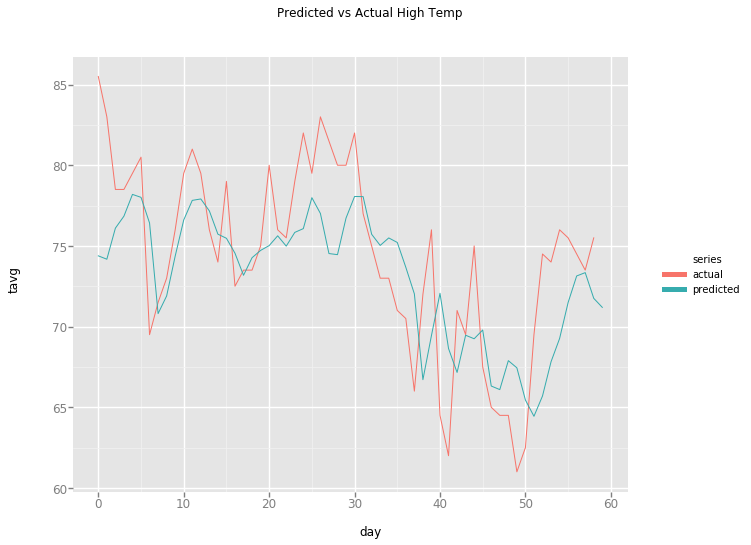

<ggplot: (8740458302938)>

In [34]:
gg.ggplot(gg.aes(x='day', y='tavg', color='series'),
          data=eval_data) + gg.geom_line() + gg.ggtitle("Predicted vs Actual High Temp")

# Persist Predictions

In [35]:
# define the schema for this dataset
schema = {
    "table_name": "rnn_weather_predictions",
    "options": {
        "primary_key": ["day", "series"],
        "order_by": ["series asc"]
    },
    "columns": {
        "day": "int",
        "tavg": "float",
        "series": "text"
    }
}

In [36]:
data_out = eval_data.dropna().drop('tavg_norm', axis=1).to_dict(orient='records')

In [37]:
skafos.engine.save(schema, data_out).result()

2018-01-05 20:56:47,054 - skafossdk.data_engine - INFO - Saving Data ...
2018-01-05 20:56:47,056 - skafossdk.data_engine - INFO - Sending msg...


{'data': [{'success': True}]}

## Accessing persisted data
Ingested data is available from the Metis Machine API using your credentials as described in the [API docs](https://docs.metismachine.io/docs/api-accessing-your-results)